# Fine-tuning a CNN with MXNet: Cats vs Dogs (Kaggle Redux)

In this tutorial we'll learn how to build a model to classifiy if an image is a cat or a dog. We'll use a pre-trained [imagenet](http://www.image-net.org/) model from the MXNet [model zoo](http://data.mxnet.io/models/). For practical problems we may not have a large dataset, hence its difficult to train these generalized models. However we can take advantage of models that are pre-trained on large dataset like imagenet where in the model has already learnt a lot of the image features. 

For example, the ImageNet dataset, the default academic benchmark, which contains 1M million images, 1000 each from 1000 separate classes. The ImageNet dataset categorically changed what was possible in computer vision. It turns out some things are possible (these days, even easy) on gigantic datasets, that simply aren't with smaller datasets. In fact, we don't know of any technique that can comparably powerful model on a similar photograph dataset but containing only, say, 10k images.

And that's a problem. Because however impressive the results of CNNs on ImageNet may be, most people aren't interested in ImageNet itself. They're interested in their own problems. Recognize people based on pictures of their faces. Distinguish between photographs of $10$ different types of corral on the ocean floor. Usually when individuals (and not Amazon, Google, or inter-institutional big science initiatives) are interested in solving a computer vision problem, they come to the table with modestly sized datasets. A few hundred examples may be common and a few thousand examples may be as much as you can reasonably ask for.

So one natural question emerges.
Can we somehow use the powerful models trained on millions of examples for one dataset,
and apply them to improve performance on a new problem 
with a much smaller dataset?
This kind of problem (learning on source dataset, bringing knowledge to target dataset),
is appropriately called *transfer learning*. 
Fortunately, we have some effective tools for solving this problem.

For deep neural networks, the most popular approach is called finetuning
and the idea is both simple and effective:

* Train a neural network on the source task $S$.
* Decapitate it, replacing it's output layer appropriate to target task $T$.
* Initialize the weights on the new output layer randomly, keeping all other (pretrained) weights the same.
* Begin training on the new dataset.

This might be clearer if we visualize the algorithm: 

![](img/fine-tune.png)


## Setting up a deep learning environment with AWS Deep Learning AMI for MXNet

In this tutorial, we are going to use [Deep Learning AMI](https://aws.amazon.com/marketplace/pp/B06VSPXKDX). The Deep Learning AMI is a base Amazon Linux image provided by Amazon Web Services for use on Amazon Elastic Compute Cloud (Amazon EC2).It is designed to provide a stable, secure, and high performance execution environment for deep learning applications running on Amazon EC2. It includes popular deep learning frameworks, including MXNet.

For setting up an Deep Learning environment on AWS using Deep Learning AMI, please read [this post on AWS AI Blog](https://aws.amazon.com/blogs/ai/the-aws-deep-learning-ami-now-with-ubuntu/) for detailed instruction. 

Or you can choose to [install MXNet](http://mxnet.io/get_started/install.html) to your own machine.

# Prerequisites

 - MXNet (0.11.0 or higher)
 - Python 2.7 or higher
 - im2rec.py (clone https://github.com/dmlc/mxnet) 
 - [recommended] Amazon EC2 instance with GPU (p2.* family) with [Deep Learning AMI](https://bit.ly/deepami)


Obtain the data set.

In [10]:
%%bash

sudo wget http://files.fast.ai/data/dogscats.zip
sudo unzip dogscats.zip
sudo rm dogscats.zip

Archive:  dogscats.zip
   creating: dogscats/
   creating: dogscats/sample/
   creating: dogscats/sample/train/
   creating: dogscats/sample/train/cats/
  inflating: dogscats/sample/train/cats/cat.2921.jpg  
  inflating: dogscats/sample/train/cats/cat.394.jpg  
  inflating: dogscats/sample/train/cats/cat.4865.jpg  
  inflating: dogscats/sample/train/cats/cat.3570.jpg  
  inflating: dogscats/sample/train/cats/cat.2266.jpg  
  inflating: dogscats/sample/train/cats/cat.9021.jpg  
  inflating: dogscats/sample/train/cats/cat.11737.jpg  
  inflating: dogscats/sample/train/cats/cat.4600.jpg  
   creating: dogscats/sample/train/dogs/
  inflating: dogscats/sample/train/dogs/dog.1402.jpg  
  inflating: dogscats/sample/train/dogs/dog.1614.jpg  
  inflating: dogscats/sample/train/dogs/dog.8643.jpg  
  inflating: dogscats/sample/train/dogs/dog.6391.jpg  
  inflating: dogscats/sample/train/dogs/dog.2423.jpg  
  inflating: dogscats/sample/train/dogs/dog.9077.jpg  
  inflating: dogscats/sample/train/d

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Next we define the function which returns the data iterators.

Create a list for training and validation set

In [11]:
%%bash

python ../src/mxnet/tools/im2rec.py --list True --recursive True cats_dogs_train dogscats/train
python ../src/mxnet/tools/im2rec.py --list True --recursive True cats_dogs_val dogscats/valid

cats 0
dogs 1
cats 0
dogs 1


Convert the images in to MXNet RecordIO format

In [12]:
%%bash

python ../src/mxnet/tools/im2rec.py --resize 224 --quality 90 --num-thread 16 cats_dogs_train.lst dogscats/train

python ../src/mxnet/tools/im2rec.py --resize 224 --quality 90 --num-thread 16 cats_dogs_val.lst dogscats/valid

Creating .rec file from /home/ubuntu/mcl311/cats_dogs_train.lst in /home/ubuntu/mcl311
time: 1.57487916946  count: 0
time: 1.67381286621  count: 1000
time: 1.42826104164  count: 2000
time: 1.19867610931  count: 3000
time: 1.26279783249  count: 4000
time: 1.29834318161  count: 5000
time: 1.31965684891  count: 6000
time: 1.23261809349  count: 7000
time: 1.24385499954  count: 8000
time: 1.27789402008  count: 9000
time: 1.15161800385  count: 10000
time: 1.25549793243  count: 11000
time: 1.27254390717  count: 12000
time: 1.25443410873  count: 13000
time: 1.26088190079  count: 14000
time: 1.23382902145  count: 15000
time: 1.28098416328  count: 16000
time: 1.30082082748  count: 17000
time: 1.17038702965  count: 18000
time: 1.19743394852  count: 19000
time: 1.32388496399  count: 20000
time: 1.25626420975  count: 21000
time: 1.06368494034  count: 22000
Creating .rec file from /home/ubuntu/mcl311/cats_dogs_val.lst in /home/ubuntu/mcl311
time: 1.15841603279  count: 0
time: 1.82060098648  count: 1

In [13]:
import mxnet as mx
import os, urllib

# CODE

In [14]:
# Data Iterators for cats vs dogs dataset
def get_iterators(batch_size, data_shape=(3, 224, 224)):
    train = mx.io.ImageRecordIter(
        path_imgrec         = './cats_dogs_train.rec', 
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        shuffle             = True,
        rand_crop           = True,
        rand_mirror         = True)
    val = mx.io.ImageRecordIter(
        path_imgrec         = './cats_dogs_val.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        rand_crop           = False,
        rand_mirror         = False)
    return (train, val)

## Dowload pre-trained model from the model zoo (Squeezenet_v1.1)

SqueezeNet is a state-of-the-art inception model based Deep Neural Network that find a good balance between classification accuracy and memory usage. Taking our computing time and resource budget into account, SqueezeNet is also the most reasonable model for us to work on. 

The smaller CNN architectures of SqueezeNet offer at least three advantages: (1) Smaller CNNs require less communication across servers during distributed training. (2) Smaller CNNs require less bandwidth to export a new model from the cloud to an autonomous car and make your iOS app overall size smaller. (3) Smaller CNNs are more feasible to deploy on mobile devices with limited memory. SqueezeNet achieves AlexNet-level accuracy on ImageNet with 50x fewer parameters. Additionally, with model compression techniques, we are able to compress SqueezeNet to less
than 0.5MB (510× smaller than AlexNet).

![alt text](https://cdn-images-1.medium.com/max/1000/1*RaSehomyb8PZbpg2xnTamQ.png "Title")

    Note: If load_checkpoint reports error, we can remove the downloaded files and try get_model again.

In [15]:
# helper functions
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)
        
def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

model_name = 'squeezenet_v1.1'
    
get_model('http://data.mxnet.io/models/imagenet/squeezenet/'+model_name, 0)
sym, arg_params, aux_params = mx.model.load_checkpoint(model_name, 0)

## Fine tuning the model


To fine-tune a network, we must first replace the last fully-connected layer with a new one that outputs the desired number of classes. We initialize its weights randomly. Then we continue training as normal. Sometimes it’s common use a smaller learning rate based on the intuition that we may already be close to a good result.

We first define a function which replaces the the last fully-connected layer for a given network.

In [16]:
def get_fine_tune_model(symbol, arg_params, num_classes, layer_name='flatten_0'):
    """
    symbol: the pre-trained network symbol
    arg_params: the argument parameters of the pre-trained model
    num_classes: the number of classes for the fine-tune datasets
    layer_name: the layer name before the last fully-connected layer
    """
    all_layers = sym.get_internals()
    #print(all_layers)
    net = all_layers[layer_name+'_output']
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
    new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})
    return (net, new_args)

## Training the model

We now define a fit function that creates an MXNet module instance that we'll bind the data and symbols to. 

init_params is called to randomly initialize parameters

set_params is called to replace all parameters except for the last fully-connected layer with pre-trained model.

#### Note: change mx.gpu to mx.cpu to run training on CPU (much slower)

In [17]:
import logging
head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)

def fit(symbol, arg_params, aux_params, train, val, batch_size, num_gpus=0, num_epoch=1, learning_rate=0.009):
    devs = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
    mod = mx.mod.Module(symbol=new_sym, context=devs)
    mod.bind(data_shapes=train.provide_data, label_shapes=train.provide_label)
    mod.init_params(initializer=mx.init.Xavier(rnd_type='gaussian', factor_type="in", magnitude=2))
    mod.set_params(new_args, aux_params, allow_missing=True)
    mod.fit(train, val, 
        num_epoch=num_epoch,
        batch_end_callback = mx.callback.Speedometer(batch_size, 10),        
        kvstore='device',
        optimizer='adam',
        optimizer_params={'learning_rate': learning_rate},
        eval_metric='acc')
    
    return mod

Now that we have the helper functions setup, we can start training.
Its recommended that you train on a GPU instance, preferably p2.* family. In this example we assume an AWS EC2 p2.xlarge, which has one NVIDIA K80 GPU.

In [18]:
# training hyperparameters
demo = True

if demo:
    epochs = 2
    learning_rate = 1e-4
else:
    epochs = 40
    learning_rate = 1e-4

num_classes = 2 # This is binary classification (dogs vs cat)
batch_per_gpu = 128
num_gpus = 1 #replace with 0 if train with CPU

(new_sym, new_args) = get_fine_tune_model(sym, arg_params, num_classes, 'flatten')

batch_size = batch_per_gpu * num_gpus
(train, val) = get_iterators(batch_size)
mod = fit(new_sym, new_args, aux_params, train, val, batch_size, num_gpus, epochs, learning_rate)
metric = mx.metric.Accuracy()
mod_score = mod.score(val, metric)
print mod_score

2017-11-16 19:38:34,476 Already bound, ignoring bind()
/usr/local/lib/python2.7/dist-packages/mxnet-0.11.0-py2.7.egg/mxnet/module/base_module.py:464: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)
2017-11-16 19:38:40,176 Epoch[0] Batch [10]	Speed: 245.43 samples/sec	accuracy=0.620028
2017-11-16 19:38:45,015 Epoch[0] Batch [20]	Speed: 264.60 samples/sec	accuracy=0.825000
2017-11-16 19:38:49,863 Epoch[0] Batch [30]	Speed: 264.09 samples/sec	accuracy=0.874219
2017-11-16 19:38:54,711 Epoch[0] Batch [40]	Speed: 264.15 samples/sec	accuracy=0.911719
2017-11-16 19:38:59,586 Epoch[0] Batch [50]	Speed: 262.63 samples/sec	accuracy=0.927344
2017-11-16 19:39:04,452 Epoch[0] Batch [60]	Speed: 263.13 samples/sec	accuracy=0.933594
2017-11-16 19:39:09,337 Epoch[0] Batch [70]	Speed: 262.10 samples/sec	accuracy=0.926562
2017-11-16 19:39:14,218 Epoch[0] Batch [80]	Speed: 262.36 samples/sec	accuracy=0.942187


[('accuracy', 0.96337890625)]


Lets save the newly trained model 

In [19]:
prefix = model_name+'-mxnet-catsvsdogs'
epoch = 1
mc = mod.save_checkpoint(prefix, epoch)

2017-11-16 19:41:41,475 Saved checkpoint to "squeezenet_v1.1-mxnet-catsvsdogs-0001.params"


## Loading saved model

In [20]:
# load the model, make sure you have executed previous cells to train
import cv2
dshape = [('data', (1,3,224,224))]

def load_model(s_fname, p_fname):
    """
    Load model checkpoint from file.
    :return: (arg_params, aux_params)
    arg_params : dict of str to NDArray
        Model parameter, dict of name to NDArray of net's weights.
    aux_params : dict of str to NDArray
        Model parameter, dict of name to NDArray of net's auxiliary states.
    """
    symbol = mx.symbol.load(s_fname)
    save_dict = mx.nd.load(p_fname)
    arg_params = {}
    aux_params = {}
    for k, v in save_dict.items():
        tp, name = k.split(':', 1)
        if tp == 'arg':
            arg_params[name] = v
        if tp == 'aux':
            aux_params[name] = v
    return symbol, arg_params, aux_params

model_symbol = model_name+'-mxnet-catsvsdogs-symbol.json'
model_params = model_name+'-mxnet-catsvsdogs-0001.params'
sym, arg_params, aux_params = load_model(model_symbol, model_params)
mod = mx.mod.Module(symbol=sym, context=mx.gpu())
mod.predict
# bind the model and set training == False; Define the data shape
mod.bind(for_training=False, data_shapes=dshape)
mod.set_params(arg_params, aux_params)

/usr/local/lib/python2.7/dist-packages/mxnet-0.11.0-py2.7.egg/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


## Generate Predictions for an arbitrary image

In [22]:
import urllib2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from collections import namedtuple

Batch = namedtuple('Batch', ['data'])

def preprocess_image(img, show_img=False):
    '''
    convert the image to a numpy array
    '''
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 
    return img

def predict(url, mod):
    req = urllib2.urlopen(url)

    image = np.asarray(bytearray(req.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    img = preprocess_image(image)
    plt.subplot(1, 1, 1)
    plt.imshow(image)
    mod.forward(Batch([mx.nd.array(img)]))

    # predict
    prob = mod.get_outputs()[0].asnumpy()
    result = np.argmax(prob)
    outstring = ['Cat', 'Dog']
    return outstring[result], prob

('Dog', array([[  1.37327689e-07,   9.99999881e-01]], dtype=float32))

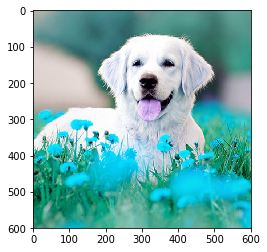

In [23]:
predict('https://www.what-dog.net/Images/faces2/scroll0015.jpg', mod)

('Cat', array([[ 0.99801791,  0.00198211]], dtype=float32))

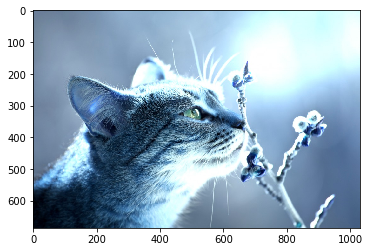

In [24]:
predict('https://www.catprotection.com.au/wp-content/uploads/2014/11/1866855-cat-m-1030x686.jpg', mod)

('Cat', array([[  9.99885678e-01,   1.14271126e-04]], dtype=float32))

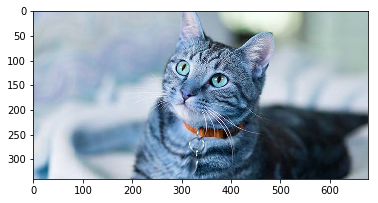

In [25]:
predict('http://www.hillspet.com/HillsPetUS/v1/portal/en/us/cat-care/images/HP_PCC_md_0130_cat53.jpg', mod)

## Convert MXNet to CoreML model

With Core ML, you can integrate trained machine learning models into your app.


A trained model is the result of applying a machine learning algorithm to a set of training data. The model makes predictions based on new input data. For example, a model that's been trained on a region's historical house prices may be able to predict a house's price when given the number of bedrooms and bathrooms.
Core ML is the foundation for domain-specific frameworks and functionality. Core ML supports Vision for image analysis, Foundation for natural language processing (for example, the NSLinguisticTagger class), and GameplayKit for evaluating learned decision trees. Core ML itself builds on top of low-level primitives like Accelerate and BNNS, as well as Metal Performance Shaders.

In [27]:
import sys
sys.path.append("../src/mxnet/tools/coreml")
sys.path.append("../src/mxnet/tools/coreml/converter/")
from converter._mxnet_converter import convert

input_shape=(1,3,224,224)
coreml_model = convert(mod, input_shape={'data': input_shape}, preprocessor_args={"image_input_names":"data"})
coreml_model.save('coreml.mlmodel')

3 : conv1, Convolution
4 : relu_conv1, Activation
5 : pool1, Pooling
8 : fire2_squeeze1x1, Convolution
9 : fire2_relu_squeeze1x1, Activation
12 : fire2_expand1x1, Convolution
13 : fire2_relu_expand1x1, Activation
16 : fire2_expand3x3, Convolution
17 : fire2_relu_expand3x3, Activation
18 : fire2_concat, Concat
21 : fire3_squeeze1x1, Convolution
22 : fire3_relu_squeeze1x1, Activation
25 : fire3_expand1x1, Convolution
26 : fire3_relu_expand1x1, Activation
29 : fire3_expand3x3, Convolution
30 : fire3_relu_expand3x3, Activation
31 : fire3_concat, Concat
32 : pool3, Pooling
35 : fire4_squeeze1x1, Convolution
36 : fire4_relu_squeeze1x1, Activation
39 : fire4_expand1x1, Convolution
40 : fire4_relu_expand1x1, Activation
43 : fire4_expand3x3, Convolution
44 : fire4_relu_expand3x3, Activation
45 : fire4_concat, Concat
48 : fire5_squeeze1x1, Convolution
49 : fire5_relu_squeeze1x1, Activation
52 : fire5_expand1x1, Convolution
53 : fire5_relu_expand1x1, Activation
56 : fire5_expand3x3, Convolution
5

Save coreml model to file

In [28]:
coreml_model.save('coreml.mlmodel')